In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Render a colored point cloud

This tutorial shows how to:
- set up a renderer 
- render the point cloud 
- vary the rendering settings such as compositing and camera position

## Import modules

If `torch`, `torchvision` and `pytorch3d` are not installed, run the following cell:

In [2]:
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [1]:
import os
os.chdir('../..')
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading point clouds
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

### Load a point cloud and corresponding colors

Load and create a **Point Cloud** object. 

**Pointclouds** is a unique datastructure provided in PyTorch3D for working with batches of point clouds of different sizes. 

If running this notebook using **Google Colab**, run the following cell to fetch the pointcloud data and save it at the path `data/PittsburghBridge`:
If running locally, the data is already available at the correct path. 

In [ ]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

In [2]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)
        
rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

## Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthgraphic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses an **orthographic camera**, and applies **alpha compositing**. Then we learn how to vary different components using the modular API.  

[1] <a href="https://arxiv.org/abs/1912.08804">SynSin: End to end View Synthesis from a Single Image.</a> Olivia Wiles, Georgia Gkioxari, Richard Szeliski, Justin Johnson. CVPR 2020.

In [3]:
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = OpenGLOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=AlphaCompositor(composite_params=None)
)


(-0.5, 511.5, 511.5, -0.5)

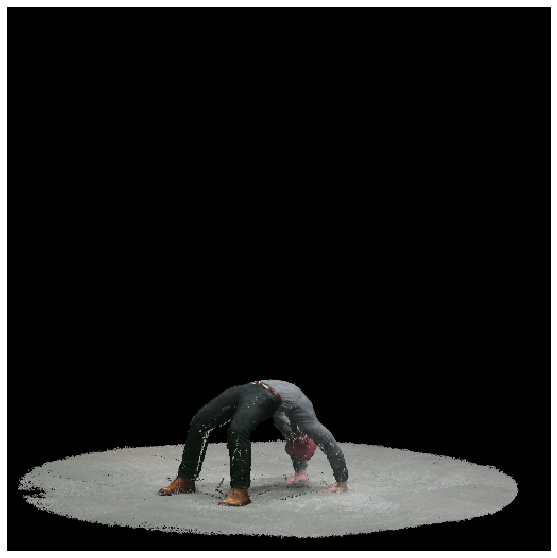

In [4]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

In this example we will first create a **renderer** which uses an **orthographic camera**, and applies **weighted compositing**. 

In [5]:
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = OpenGLOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an weighted compositor (3D points are
# weighted according to their distance to a pixel and accumulated using a weighted sum)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor(composite_params=None)
)


(-0.5, 511.5, 511.5, -0.5)

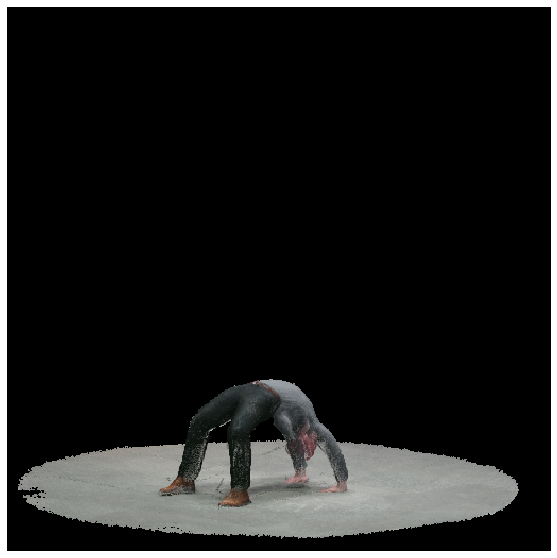

In [6]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")